# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# magic word for producing visualizations in notebook
%matplotlib inline

In [4]:
pd.__version__

'1.1.5'

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [6]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Read in the DIAS Information Levels - Attributes 2017 as FEATURES and DIAS Attributes - Values 2017 as VALUES.

In [9]:
features = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)
del features['Unnamed: 0']
values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
del values['Unnamed: 0']

In [10]:
features.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [11]:
values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


## 0.1 Feature organization

First we take a look a general look at the data shape.

In [12]:
azdias.shape

(891221, 366)

In [13]:
customers.shape

(191652, 369)

CUSTOMERS has three more features than AZDIAS, which are PRODUCT_GROUP, ONLINE_PURCHASE and CUSTOMER_GROUP.

In [14]:
customers[list(set(customers.columns.to_list()) - set(azdias.columns.to_list()))]

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0
...,...,...,...
191647,COSMETIC_AND_FOOD,MULTI_BUYER,0
191648,COSMETIC,SINGLE_BUYER,0
191649,COSMETIC_AND_FOOD,MULTI_BUYER,0
191650,FOOD,SINGLE_BUYER,0


However, not all  features in AZDIAS ans CUSTOMERS are explained in the information spreedsheets, FEATURES and VALUES. Only 313 features are explained in FEATURES and 315 in VALUES.

In [15]:
# the number of features in df features
print(len(features['Attribute'].unique()))
# the number of features in df values
print(len(values['Attribute'].unique()))

313
315


In [16]:
# the number of common featrues in between azdias and df features
print(len(set(features['Attribute'].unique()).intersection(set(azdias.columns))))
# the number of common featrues in between azdias and df values
print(len(set(values['Attribute'].unique()).intersection(set(azdias.columns))))

264
272


Next we want to see if there any feature that have different names in VALUES and AZDIAS.

In [17]:
# the features that are in AZDIAZ but not in VALUES
set(values['Attribute'].unique()).union(set(azdias.columns)) - set(values['Attribute'].unique())

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSICHERUNGEN',
 '

In [18]:
#the features that are in VALUEs but not in AZDIAS
diff = sorted(list(set(values['Attribute'].dropna().unique()).union(set(azdias.columns)) - set(azdias.columns)))
diff

['BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB']

We can see some features' names beginning with D_19 in VALUES are very similiar to those in AZDIAS, but with a '_RZ'. Here we transform them to match those in AZDIAS.

In [19]:
# fill the NaNs in VALUES with ffill method
values.fillna(method='ffill', inplace=True)

In [20]:
for i in range(len(values)):
    if values['Attribute'].iloc[i] in diff[2:-4]:
        values['Attribute'].iloc[i] = values['Attribute'].iloc[i][0:-3]

Also, the CAMEO_DEUINTL_2015 in VALUES is actually CAMEO_INTL_2015 in AZDIAS and CUSTOMERS.

In [21]:
for i in range(len(values)):
    if values['Attribute'].iloc[i] == 'CAMEO_DEUINTL_2015':
        values['Attribute'].iloc[i] = 'CAMEO_INTL_2015'

Also, feature KBA13_CCM_1400_2500 in VALUES is quite similiar with KBA13_CCM_1401_2500 in AZDIAS. And we find that 1400-2500 is a range and that won't make big difference with 1401-2500. Hence we would change 1400-2500 to 1401-2500 in VALUES.

In [22]:
for i in range(len(values)):
    if values['Attribute'].iloc[i] == 'KBA13_CCM_1400_2500':
        values['Attribute'].iloc[i] = 'KBA13_CCM_1401_2500'

At last, there are still 59 features in AZDIAS that are not in VALUES. We will just keep them unchanged.

In [23]:
unknown_features = set(azdias.columns)- set(values['Attribute'].dropna().unique()).intersection(set(azdias.columns))
print(len(unknown_features))
unknown_features

59


{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BUCH_CD',
 'D19_KONSUMTYP_MAX',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSI_ONLINE_QUOTE_12',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'KBA13_ANTG2',
 'KBA13_ANTG3',
 'KBA13_ANTG4',
 'KBA13_BAUMAX',
 'KBA13_GBZ',
 'KBA13_HHZ',
 'KBA13_KMH_210',
 'KK_KUNDENTYP',
 'KOMBIALTER',
 'KONSUMZELLE',
 'LNR',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'SOHO_KZ',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VHA',
 'VHN',
 'VK_DHT4A',
 'VK_

## 0.2 Unexpected Values
In this part, we check if all the values of each feature are in the possible range of that feature in VALUES dataframe.

In [24]:
def get_ranges(values):
    '''
    Return a dictionary, in which keys are features and values are the possible values of that feature.
    '''
    ranges = {}
    for i in range(len(values)):
        feature = values['Attribute'].iloc[i]
        value = values['Value'].iloc[i]
        
        if feature in ranges:
            if type(value) == str:
                try:
                    for i in value.split(','):
                        ranges[feature].append(int(i))
                except:
                    ranges[feature].append(value)
            else:
                ranges[feature].append(value)

        else:
            if value == '…':
                continue
            elif type(value) == str:
                try:
                    ranges[feature] = [int(i) for i in value.split(',')]
                except:
                    ranges[feature] = [value]
            else:
                ranges[feature] = [value]
                
    
#    for feature, value in ranges.items():
#        ranges[feature].append(np.nan)
                
    return ranges

ranges = get_ranges(values)

In [25]:
for feature, value in ranges.items():
    try:
        azi = set(azdias[feature].dropna().unique())
        if azi.issubset(set(value)) == False:
            print(feature, 'has unexpected value:', azi - set(ranges[feature]))

    except:
        continue

CAMEO_DEUG_2015 has unexpected value: {'9', '7', '4', '8', 'X', '3', '6', '2', '1', '5'}
CAMEO_DEU_2015 has unexpected value: {'XX'}
CAMEO_INTL_2015 has unexpected value: {'22', '15', '14', '43', '52', 'XX', '25', '31', '41', '44', '51', '12', '35', '23', '34', '33', '24', '32', '13', '45', '55', '54'}
KBA05_MODTEMP has unexpected value: {6.0}
LP_FAMILIE_FEIN has unexpected value: {0.0}
LP_FAMILIE_GROB has unexpected value: {0.0}
LP_LEBENSPHASE_FEIN has unexpected value: {0.0}
LP_LEBENSPHASE_GROB has unexpected value: {0.0}
ORTSGR_KLS9 has unexpected value: {0.0}


In [26]:
for feature, value in ranges.items():
    try:
        cos = set(customers[feature].dropna().unique())
        if cos.issubset(set(value)) == False:
            print(feature, 'has unexpected value:', cos - set(ranges[feature]))

    except:
        continue

Here we see that there are 7 features having values that are not in the possible range in AZDIAS but 0 in CUSTOMERS. Hence we don't need to transform anything in CUSTOMERS. We would compare the unexpected values with the original range, find out the mistake and do some transformation for the 7 features in AZIDAS in one function.

   1. For CAMEO_DEUG_2015, the string of number should be turned to int type and 'X' should be NaNs


In [27]:
azdias['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

2. For CAMEO_DEU_2015, 'XX' should be np.nan since there are no other value representing NaNs and the number of 'XX' is quite small.

In [28]:
azdias['CAMEO_DEU_2015'].value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64

  2. For CAMEO_INTL_2015, the string of number should be turned to int type and 'XX' should be NaNs.

In [29]:
azdias['CAMEO_INTL_2015'].value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

   3. For KBA05_MODTEMP, value 6.0 should be transformed as NaNs as sample size of 6.0 is relatively small and the original {-1, 9} which should represent NaNs is missing. 

In [30]:
azdias['KBA05_MODTEMP'].value_counts()

3.0    267178
4.0    226782
1.0    151667
2.0     77576
5.0     65321
6.0      9549
Name: KBA05_MODTEMP, dtype: int64

   4. For LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN , LP_LEBENSPHASE_GROB, they are categorical features of same type. The 0's in these features should be transformed to NaNs. 

In [31]:
azdias['LP_FAMILIE_FEIN'].value_counts()

1.0     426379
10.0    137913
2.0     104305
0.0      72938
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64

   5. For ORTSGR_KLS9, -1 was supposed to represent NaNs but there aren't any. Hence here 0 is the real number for NaNs.

In [32]:
azdias['ORTSGR_KLS9'].value_counts()

5.0    148096
4.0    114909
7.0    102866
9.0     91879
3.0     83542
6.0     75995
8.0     72709
2.0     63362
1.0     40589
0.0        58
Name: ORTSGR_KLS9, dtype: int64

Here we use a function to clean the data mentioned above.

In [33]:
def feature_trans(x):
    '''
    Clean the 'XX' and string of numbers in CAMEO_DEUINTL_2015.
    '''
    if pd.isnull(x) != True:
        try:
            return int(x)
        except:
            return np.nan



def transform_unexpected(df):
    '''
    Transform the expected value into normal ones.
    
    '''
    df['ORTSGR_KLS9'] = df['ORTSGR_KLS9'].replace({0.0:np.nan})
    df[['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN' , 'LP_LEBENSPHASE_GROB']] = df[['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN' , 'LP_LEBENSPHASE_GROB']].replace({0.0:np.nan})
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({'XX':np.nan})
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(feature_trans)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(feature_trans)
    df['KBA05_MODTEMP'] = df['KBA05_MODTEMP'].replace({6.0:np.nan})
    
transform_unexpected(azdias)




## 0.3 Clean the object type

In this part, we tried to turn the columns that are object type into int/float type which they should be.

In [34]:
azdias.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

There are 4 columns that are Object type. (There should be more but we cleaned them in the previous part).


In [35]:
azdias.select_dtypes('object')

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...
891216,7A,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,D19_UNBEKANNT,1992-02-12 00:00:00,W


For features that are string or timestamp type, we consider them to be transformed as int/float type for better classification. However, D19_LETZTER_KAUF_BRANCHE and EINGEFUEGT_AM are not in VALUES so we have no idea about what they mean and their possible ranges. Hence we better drop these columns. 

And for OST_WEST_KZ and CAMEO_DEU_2015, we would use int numbers to replace the original value.

In [36]:
azdias.drop(columns=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], inplace=True)
customers.drop(columns=['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], inplace=True)

In [37]:
# Clean OST_WEST_KZ
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace({'O':0, 'W':1})

In [38]:
# Clean CAMEO_DEU_2015
val_dict = dict(zip(ranges['CAMEO_DEU_2015'], np.linspace(1, len(ranges['CAMEO_DEU_2015']), len(ranges['CAMEO_DEU_2015']))))
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].replace(val_dict)

## 0.4 Missing Values

In different feature columns, the NaN are being represented by different numbers, such as -1, 9. Taking advantage of the Values dataframe, we can transformall those number into NaNs.

In [39]:
def find_unknown_code(df=values):
    '''
    Find the rows where the value is for unknown information in VALUES.
    
    params: df: the VALUES dataframe.
    return: a sub-dataframe of the VALUES that Value column only contains values for unknown information.
    '''
    rows = []
    for i in range(len(df)):
        if 'unknown' in df.iloc[i]['Meaning']:
            rows.append(i)
            
    return df.iloc[rows]

unknown_code = find_unknown_code()
unknown_code.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [40]:
def to_int_list(x):
    '''
    Turn  either an int type number or a string of multiple numbers into a int list.
    
    params: x: an int number or a string of numbers and commas
    return: a list of integers
    '''
    if type(x) == int:
        return [x]
    else:
        return [ int(i) for i in x.split(',')]

# Turn the value of Value column into list
unknown_code['Value'] = unknown_code['Value'].apply(to_int_list)
unknown_code.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,[-1],unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",unknown
11,ALTER_HH,main age within the household,[0],unknown / no main age detectable
33,ANREDE_KZ,gender,"[-1, 0]",unknown
40,BALLRAUM,distance to next urban centre,[-1],unknown


In [41]:
def transform_unknown_code(df1=azdias, df2=unknown_code):
    '''
    Transform the unknown code to np.nan.
    '''
    count = 1
    for idx in range(len(df2)):
        feature = df2.iloc[idx]['Attribute']
        code = df2.iloc[idx]['Value']
        try:
            df1[feature] = df1[feature].apply(lambda x: np.nan if x in code else x)
            count += 1
            if count % 5 == 0:
                print(count, 'features are transformed.')
            
        except:
            continue
    
    print(count, 'features are transformed.')

Transform the unknown code in AZDIAS and CUSTOMERS into NaNs. We can see there are 228 features in AZDIAS and CUSTOMERS that are transformed.

In [42]:
transform_unknown_code()

5 features are transformed.
10 features are transformed.
15 features are transformed.
20 features are transformed.
25 features are transformed.
30 features are transformed.
35 features are transformed.
40 features are transformed.
45 features are transformed.
50 features are transformed.
55 features are transformed.
60 features are transformed.
65 features are transformed.
70 features are transformed.
75 features are transformed.
80 features are transformed.
85 features are transformed.
90 features are transformed.
95 features are transformed.
100 features are transformed.
105 features are transformed.
110 features are transformed.
115 features are transformed.
120 features are transformed.
125 features are transformed.
130 features are transformed.
135 features are transformed.
140 features are transformed.
145 features are transformed.
150 features are transformed.
155 features are transformed.
160 features are transformed.
165 features are transformed.
170 features are transformed.


In [43]:
transform_unknown_code(df1=customers)

5 features are transformed.
10 features are transformed.
15 features are transformed.
20 features are transformed.
25 features are transformed.
30 features are transformed.
35 features are transformed.
40 features are transformed.
45 features are transformed.
50 features are transformed.
55 features are transformed.
60 features are transformed.
65 features are transformed.
70 features are transformed.
75 features are transformed.
80 features are transformed.
85 features are transformed.
90 features are transformed.
95 features are transformed.
100 features are transformed.
105 features are transformed.
110 features are transformed.
115 features are transformed.
120 features are transformed.
125 features are transformed.
130 features are transformed.
135 features are transformed.
140 features are transformed.
145 features are transformed.
150 features are transformed.
155 features are transformed.
160 features are transformed.
165 features are transformed.
170 features are transformed.


After we got all the NaNs in each feature, now we would like to see the precentage of null values in each feature in AZDIAS and CUSTOEMRS.

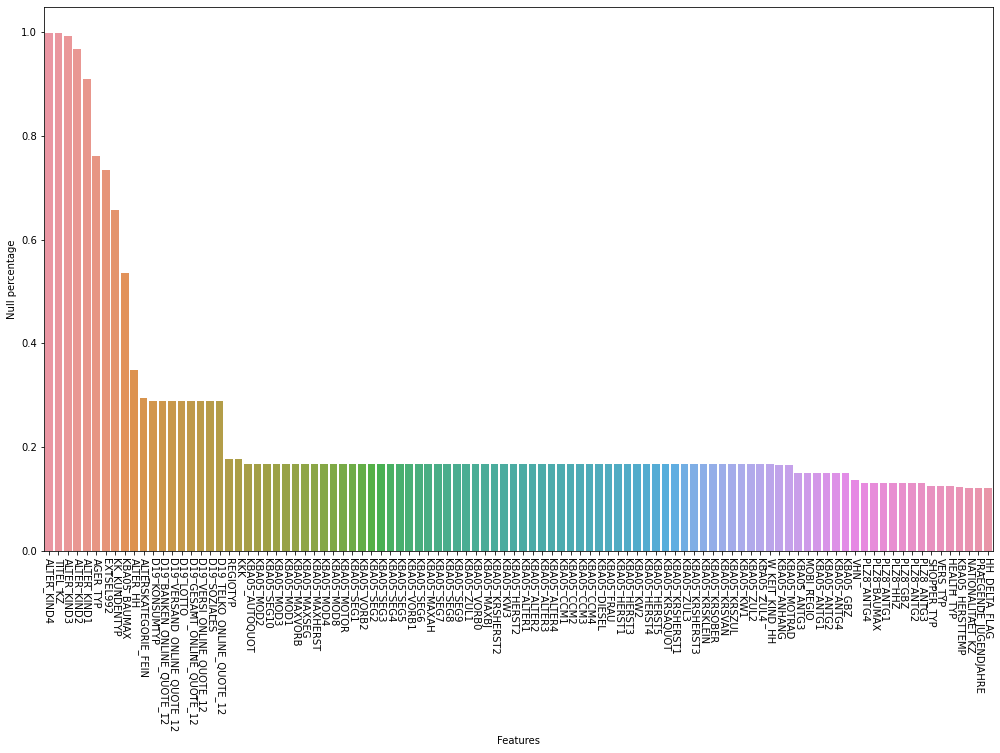

In [44]:
nan_pctg_azi = azdias.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(17, 10))
sns.barplot(x=nan_pctg_azi.reset_index()[0:100]['index'], y=nan_pctg_azi.reset_index()[0:100][0])
plt.xticks(rotation=270);
plt.xlabel('Features');
plt.ylabel('Null percentage');

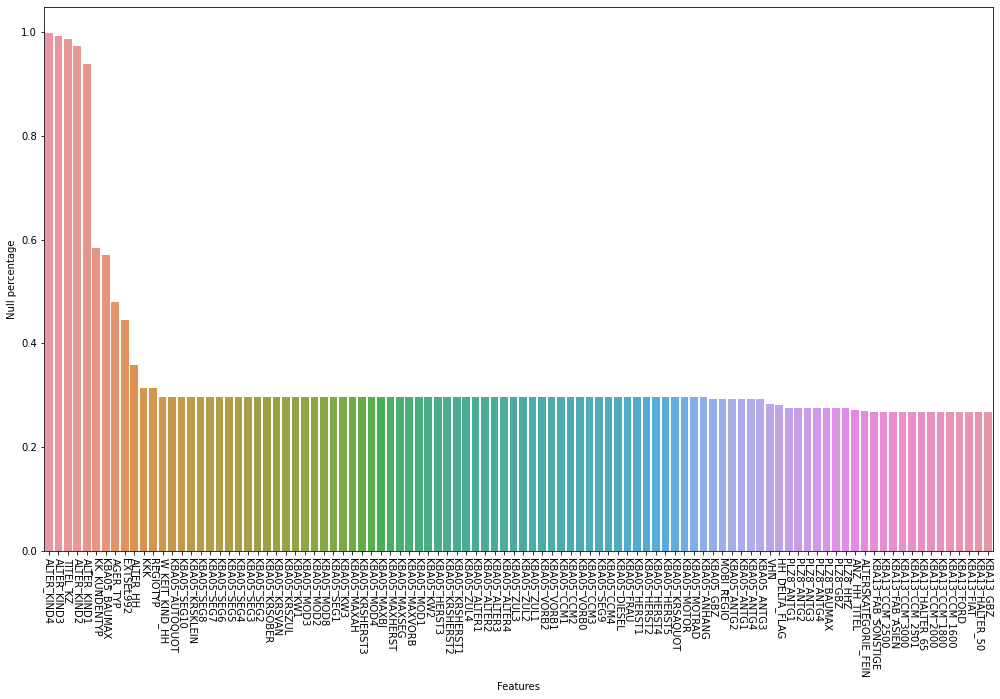

In [45]:
nan_pctg_cus = customers.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(17, 10))
sns.barplot(x=nan_pctg_cus.reset_index()[0:100]['index'], y=nan_pctg_cus.reset_index()[0:100][0])
plt.xticks(rotation=270);
plt.xlabel('Features');
plt.ylabel('Null percentage');

From the two graphs above, we can see that the first 11 features that have most NaNs are exactly same for AZIDAS and CUSTOMERS. For other features, the NaNs in AZIDAS are roughly 10% less than those in CUSTOMERS. Here, we decide to drop the first 11 features that have most NaNs. 

In [46]:
drop_col = nan_pctg_cus.reset_index()[0:11]['index'].tolist()
drop_col

['ALTER_KIND4',
 'ALTER_KIND3',
 'TITEL_KZ',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'AGER_TYP',
 'EXTSEL992',
 'ALTER_HH',
 'KKK']

In [47]:
azdias.drop(columns=drop_col, inplace=True)
customers.drop(columns=drop_col, inplace=True)

After we drop the features that contains too many NaNs, we should also consider the people whose infomation is largely lost, i.e the people who have too many NaNs for features. And if the percentage of NaNs exceeds some threshold, we drop that row.

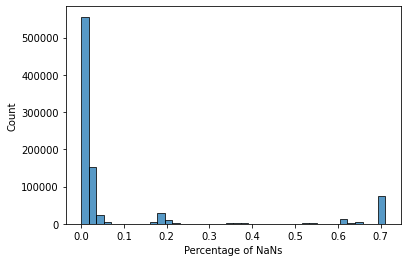

In [48]:
sns.histplot(azdias.isnull().mean(axis=1), bins=40);
plt.xlabel('Percentage of NaNs');

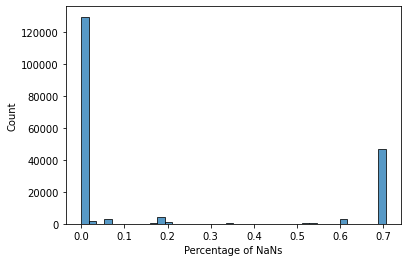

In [49]:
sns.histplot(customers.isnull().mean(axis=1), bins=40);
plt.xlabel('Percentage of NaNs');

We can see that most population or customers have NaNs less than 10%. Hence would take 10% as the threshold. Any row in AZDIAS and CUSTOMERS that has NaNs more than 10% will be droped.

In [50]:
azdias = azdias.iloc[np.where(azdias.isnull().mean(axis=1) <= 0.1)]

In [51]:
customers = customers.iloc[np.where(customers.isnull().mean(axis=1) <= 0.1)]

At last step, we would fill all the NaNs in AZDIAS and CUSTOMERS with the mode in each feature.

In [52]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [53]:
azdias = imputer.fit_transform(azdias)

In [54]:
customers = imputer.fit_transform(customers)

## 0.4 Correlated features

Some features in our AZDIAS dataset may be highly correlated, which may affect the accuracy of prediction model. In this part, we calculate the correlation cofficients between features and list the features that has correlation larger than 0.9.

In [4]:
for i in range(azdias.shape[1] - 1):
    for j in range(i + 1, azdias.shape[1]):
        correlation = np.corrcoef(azdias.iloc[:, i], azdias.iloc[:, j])[0][1]
        if np.abs(correlation) >= 0.9:
            print(azdias.columns[[i, j]].tolist(), correlation)

['ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE'] 0.9818120465146686
['CAMEO_DEU_2015', 'CAMEO_DEUG_2015'] 0.9921050481201125
['CAMEO_DEU_2015', 'CAMEO_INTL_2015'] 0.9596235754095342
['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] 0.9554802684143703
['D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24'] 0.9029577487267255
['D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_12'] 0.9027852916956708
['D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_24'] 0.9155546389240952
['D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM'] 0.9059316394341194
['D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM'] 0.9395187053332912
['D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12'] 0.9232591954849385
['D19_KONSUMTYP', 'D19_KONSUMTYP_MAX'] 0.9057833443849734
['D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'] 0.9047037084247113
['D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM'] 0.9545323195576896
['GEMEINDETYP', 'ORTSGR_KLS9'] -0.9342464192492558
['KBA13_ALTERHALTER_61', 'KBA13_HALTER_66'] 0.9275994829618076
['KBA13_ANTG1', 'PLZ8_ANTG1'] 0.918155

Checking all the correlated features above, we decide to drop following columns in AZDIAS.

In [5]:
high_correlated = ['ANZ_HAUSHALTE_AKTIV', 'CAMEO_DEU_2015',
'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_DATUM'
, 'KBA13_ALTERHALTER_61', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_BAUMAX', 'KBA13_HERST_SONST','PLZ8_GBZ',
 'PLZ8_HHZ', 'KBA13_KMH_250', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB']

In [6]:
azdias.drop(columns=high_correlated, inplace=True)

## 0.5 Data cleaning function

In this part, we create a function that cleans AZDIAS and CUSTOMERS with all the steps above.

In [52]:
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
features = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)
del features['Unnamed: 0']
values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
del values['Unnamed: 0']

def clean_values(df=values):
    '''
    Correct the feature names in VALUES to match those in AZDIAS.
    return: None
    '''
    df.fillna(method='ffill', inplace=True)
    diff = [ 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ','D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_REST_RZ',
            'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ',
             'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ',
            'D19_GARTEN_RZ', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ',
            'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ',
            'D19_REISEN_RZ', 'D19_SAMMELARTIKEL_RZ','D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ', 'D19_TECHNIK_RZ',
            'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST_RZ', 'D19_TIERARTIKEL_RZ', 'D19_VERSAND_REST_RZ',
            'D19_VERSICHERUNGEN_RZ', 'D19_VOLLSORTIMENT_RZ', 'D19_WEIN_FEINKOST_RZ',]
    
    for i in range(len(values)):
        if df['Attribute'].iloc[i] == 'CAMEO_DEUINTL_2015':
            df['Attribute'].iloc[i] = 'CAMEO_INTL_2015'
            
    
            
    for i in range(len(values)):
        if df['Attribute'].iloc[i] in diff:
            df['Attribute'].iloc[i] = df['Attribute'].iloc[i][0:-3]
        
    for i in range(len(values)):
        if df['Attribute'].iloc[i] == 'KBA13_CCM_1400_2500':
            df['Attribute'].iloc[i] = 'KBA13_CCM_1401_2500'
            
    
    
    
clean_values(values)

In [4]:
def clean_data(df):
    '''
    Clean the AZDIAS dataset based on previous steps and return a new cleaned AZDIAS.
    '''
    
    def feature_trans(x):
        '''
        Clean the 'XX' and string of numbers.
        '''
        if pd.isnull(x) != True:
            try:
                return int(x)
            except:
                return np.nan
    
    df['ORTSGR_KLS9'] = df['ORTSGR_KLS9'].replace({0.0:np.nan})
    df[['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN' , 'LP_LEBENSPHASE_GROB']] = df[['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN' , 'LP_LEBENSPHASE_GROB']].replace({0.0:np.nan})
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({'XX':np.nan})
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(feature_trans)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(feature_trans)
    df['KBA05_MODTEMP'] = df['KBA05_MODTEMP'].replace({6.0:np.nan})
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O':0, 'W':1})
    
    ranges = ['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', 
              '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', 
              '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', 
              '9A', '9B', '9C', '9D', '9E']
    val_dict = dict(zip(ranges, np.linspace(1, len(ranges), len(ranges))))
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(val_dict)
    
    rows = []
    for i in range(len(values)):
        if 'unknown' in values.iloc[i]['Meaning']:
            rows.append(i)
    unknown_code = values.iloc[rows]
    
    def to_int_list(x):
        '''
        Turn  either an int type number or a string of multiple numbers  into a int list.

        '''
        if type(x) == int:
            return [x]
        else:
            return [ int(i) for i in x.split(',')]


    unknown_code['Value'] = unknown_code['Value'].apply(to_int_list)
    
    count = 1
    for idx in range(len(unknown_code)):
        feature = unknown_code.iloc[idx]['Attribute']
        code = unknown_code.iloc[idx]['Value']
        try:
            df[feature] = df[feature].apply(lambda x: np.nan if x in code else x)
            count += 1
            if count % 5 == 0:
                print(count, 'features are transformed.')
            
        except:
            continue
    print(count, 'features are transformed.')
    
    
    df = df.iloc[np.where(df.isnull().mean(axis=1) <= 0.1)]
    
    drop_cols = ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'ALTER_KIND4', 'ALTER_KIND3',
                 'TITEL_KZ', 'ALTER_KIND2' ,'ALTER_KIND1', 'KK_KUNDENTYP', 'KBA05_BAUMAX',
                 'AGER_TYP', 'EXTSEL992', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'LNR']
    df.drop(columns=drop_cols, inplace=True)
    
    high_correlated = ['ANZ_HAUSHALTE_AKTIV', 'CAMEO_DEU_2015',
                    'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_DATUM'
                    , 'KBA13_ALTERHALTER_61', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_BAUMAX', 'KBA13_HERST_SONST','PLZ8_GBZ',
                     'PLZ8_HHZ', 'KBA13_KMH_250', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB']
    df.drop(columns=high_correlated, inplace=True)
    
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    return df

In [12]:
cleaned_azdias = clean_data(azdias)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5 features are transformed.
10 features are transformed.
15 features are transformed.
20 features are transformed.
25 features are transformed.
30 features are transformed.
35 features are transformed.
40 features are transformed.
45 features are transformed.
50 features are transformed.
55 features are transformed.
60 features are transformed.
65 features are transformed.
70 features are transformed.
75 features are transformed.
80 features are transformed.
85 features are transformed.
90 features are transformed.
95 features are transformed.
100 features are transformed.
105 features are transformed.
110 features are transformed.
115 features are transformed.
120 features are transformed.
125 features are transformed.
130 features are transformed.
135 features are transformed.
140 features are transformed.
145 features are transformed.
150 features are transformed.
155 features are transformed.
160 features are transformed.
165 features are transformed.
170 features are transformed.


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
cleaned_customers = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5 features are transformed.
10 features are transformed.
15 features are transformed.
20 features are transformed.
25 features are transformed.
30 features are transformed.
35 features are transformed.
40 features are transformed.
45 features are transformed.
50 features are transformed.
55 features are transformed.
60 features are transformed.
65 features are transformed.
70 features are transformed.
75 features are transformed.
80 features are transformed.
85 features are transformed.
90 features are transformed.
95 features are transformed.
100 features are transformed.
105 features are transformed.
110 features are transformed.
115 features are transformed.
120 features are transformed.
125 features are transformed.
130 features are transformed.
135 features are transformed.
140 features are transformed.
145 features are transformed.
150 features are transformed.
155 features are transformed.
160 features are transformed.
165 features are transformed.
170 features are transformed.


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
# Save the cleaned data
# cleaned_azdias.to_csv('cleaned_azdias.csv')
# cleaned_customers.to_csv('cleaned_customers.csv')

## 0.6 Feature scaling

In this part, we would normalize the features for following machine learning processes.

In [5]:
# cleaned_azdias = pd.read_csv('cleaned_azdias.csv', index_col=False)
# del cleaned_azdias['Unnamed: 0']
# cleaned_customers = pd.read_csv('cleaned_customers.csv', index_col=False)
# del cleaned_customers['Unnamed: 0']

In [9]:
scaler = StandardScaler()
scaler.fit(cleaned_azdias)

StandardScaler()

In [10]:
scaled_azdias = pd.DataFrame(scaler.transform(cleaned_azdias), columns=cleaned_azdias.columns)
# cleaned_customers = StandardScaler().fit_transform(cleaned_customers)

In [11]:
scaled_customers = pd.DataFrame(scaler.transform(cleaned_customers), columns=cleaned_customers.columns)

In [12]:
scaled_azdias.head()

,AKT_DAT_KL,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.262209,-0.125286,-0.299108,0.224383,0.335475,-0.060668,-0.183285,0.849495,0.974129,1.088371,...,1.375915,0.696528,1.065485,1.456932,-0.747485,0.547563,-0.028587,1.141763,0.958603,-1.682327
1,1.262209,-0.125286,-0.299108,-0.634666,-0.031788,-0.060668,-0.183285,-0.980634,-0.633454,-0.836534,...,-0.354961,1.047045,0.451601,0.025346,-0.747485,0.547563,-1.083095,1.141763,0.958603,0.167980
2,-0.934274,-0.125286,-0.299108,-1.493715,-0.399050,-0.060668,-1.187381,-0.065570,-1.437246,-1.692048,...,-2.085837,0.346012,0.758543,1.814829,0.952209,0.547563,1.553174,-0.279234,0.958603,1.093134
3,-0.934274,-0.125286,-0.299108,1.942480,-0.325598,-0.060668,0.820812,-0.980634,0.170337,0.518028,...,-0.354961,-1.056054,-0.776167,-0.690447,-1.314049,0.547563,-0.555841,0.431265,-1.043185,0.167980
4,-0.934274,-0.125286,-0.299108,-0.634666,-0.399050,-0.060668,-1.187381,0.849495,0.974129,1.302249,...,-0.354961,1.397561,-0.162283,-0.690447,0.952209,0.547563,1.553174,0.431265,0.958603,-1.682327


## Part 1: Customer Segmentation Report

There are 3 subsections in this part. 1.1 and 1.2 are unsupervised learning methods for classifying population and customers to report the customer segmentation. 1.3 explained what the meaning of segmentation is.

## 1.1 Dimensionality reduction with PCA

First, we would use PCA to reduce the demension of SCALED_AZDIAS.

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA()
pca.fit(scaled_azdias)

PCA()

In [15]:
var_ratio = pca.explained_variance_ratio_

acc_ratio = []
for i in range(1, len(var_ratio)):
    acc_ratio.append(np.sum(var_ratio[0: i]))

We plot the relationship between explained variance ratio and the number of PCA components. We could found that 118 features explain  80% of the variance and 173 features can explain 90% of the variance. We decide to take 173 as the number of dimension with PCA. 

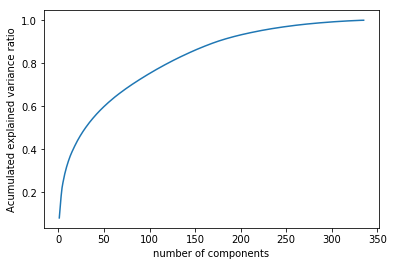

In [16]:
plt.plot(range(1, len(acc_ratio)+1), acc_ratio)
plt.xlabel('number of components');
plt.ylabel('Acumulated explained variance ratio');
plt.legend()

In [17]:
np.where(np.array(acc_ratio) > 0.8)[0][0]

120

In [18]:
np.where(np.array(acc_ratio) > 0.9)[0][0]

173

In [19]:
pca_90_pctg = PCA(0.9)
pca_90_pctg.fit(scaled_azdias)

PCA(n_components=0.9)

Apply the PCA model with 173 components onto CLEANED_AZDIAS and CLEANED_CUSTOMERS.

In [20]:
pca_azdias = pca_90_pctg.transform(scaled_azdias)

In [21]:
pca_customers = pca_90_pctg.transform(scaled_customers)

## 1.2 Cluster with K-means 

In this part, we would use k-means to find the customer segmentation.

In [22]:
def get_K_means(n_cluster):
    '''
    Find the score for K-means models with different numbers of cluster.
    
    params: n_cluster: list of int
    return: list of scores
    '''
    scores = []
    
    for n in n_cluster:
        print('Now apply Kmeans with {} clusters'.format(n))
        model = KMeans(n_clusters=n)
        model.fit(pca_azdias)
        score = abs(model.score(pca_azdias))
        print('score:', score)
        scores.append(score)
    
    return scores

We use the Elbow method to find the optimal number of clusters.

In [23]:
# set the possible range of cluster number
n_cluster = np.arange(1, 21) 
# get the scores for each number
scores = get_K_means(n_cluster)

Now apply Kmeans with 1 clusters
score: 222865909.3500473
Now apply Kmeans with 2 clusters
score: 208792480.65537408
Now apply Kmeans with 3 clusters
score: 202149364.94298247
Now apply Kmeans with 4 clusters
score: 197704832.99625254
Now apply Kmeans with 5 clusters
score: 194248494.45563498
Now apply Kmeans with 6 clusters
score: 191444733.73467958
Now apply Kmeans with 7 clusters
score: 189077376.37127668
Now apply Kmeans with 8 clusters
score: 187288186.5019096
Now apply Kmeans with 9 clusters
score: 185686813.68699217
Now apply Kmeans with 10 clusters
score: 184400491.82029536
Now apply Kmeans with 11 clusters
score: 183190126.93850213
Now apply Kmeans with 12 clusters
score: 182202325.30236316
Now apply Kmeans with 13 clusters
score: 181355342.28631613
Now apply Kmeans with 14 clusters
score: 180461832.97577855
Now apply Kmeans with 15 clusters
score: 179504247.05674455
Now apply Kmeans with 16 clusters
score: 178738179.54974312
Now apply Kmeans with 17 clusters
score: 177943992.

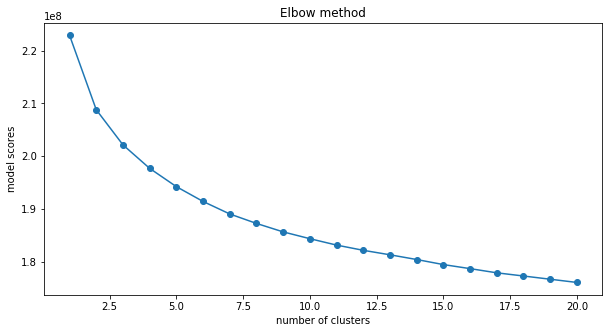

In [24]:
plt.figure(figsize=(10,5))
plt.plot(n_cluster, scores, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('model scores')
plt.title('Elbow method')
plt.legend()

From the above picture, we can see that when the number of cluster is larger than 10, the absolute score of model would decrease more slowly. Hence we would choose 10 as the number of cluster.

In [25]:
kmean_10 = KMeans(n_clusters=10, random_state=42)
kmean_10.fit(pca_azdias)

KMeans(n_clusters=10, random_state=42)

In [26]:
# classify SCALED_AZDIAS and SCALED_CUSTOMERS into 10 clusters
customers_pred = kmean_10.predict(pca_customers)
azdias_pred = kmean_10.predict(pca_azdias)

In [27]:
def get_distribution(ratio=False):
    '''
    Plot the distribution of general population and customers in 10 clusters. If ratio is true, 
    the y axis of the plot is the real amount. If ratio is false,  the y axis of the plot is the precentage.
    
    params: ratio: boolean
    
    '''
    x = np.arange(0, 10)
    azi_count = []
    cus_count = []
    plt.figure(figsize=(15, 8))
    
    if ratio:
        for i in x:
            azi_count.append(len(np.where(np.array(azdias_pred) == i)[0])/len(azdias_pred))
            cus_count.append(len(np.where(np.array(customers_pred) == i)[0])/len(customers_pred))
            
        plt.bar(x-0.2, azi_count, label='percentage of General population', width=0.4)
        plt.bar(x+0.2, cus_count, label='percentage of Customers', width=0.4)
        plt.xlabel('Groups')
        plt.ylabel('Percentage of people')
    else:
        for i in x:
            azi_count.append(len(np.where(np.array(azdias_pred) == i)[0]))
            cus_count.append(len(np.where(np.array(customers_pred) == i)[0]))
            
        plt.bar(x-0.2, azi_count, label='General population', width=0.4)
        plt.bar(x+0.2, cus_count, label='Customers', width=0.4)
        plt.xlabel('Groups')
        plt.ylabel('Amount of people')
    
    
    
    plt.xticks(x)
    plt.legend()

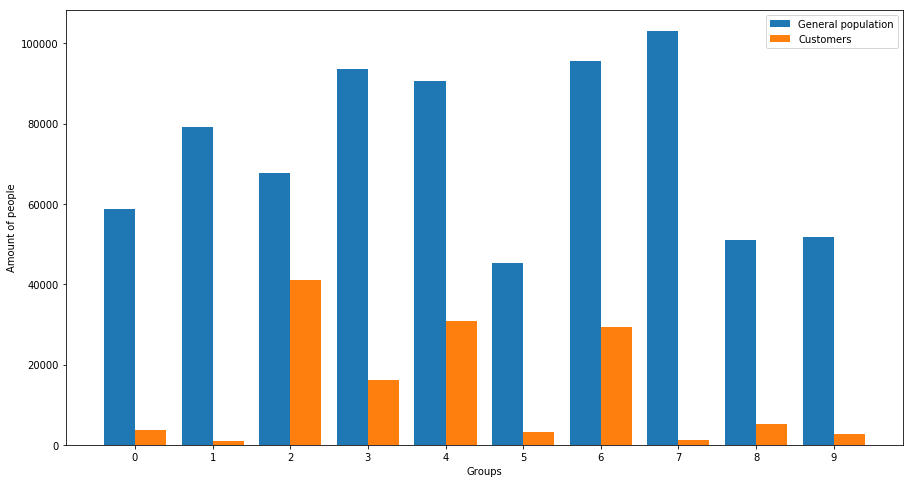

In [28]:
# PLot the distribution of real amount
get_distribution()

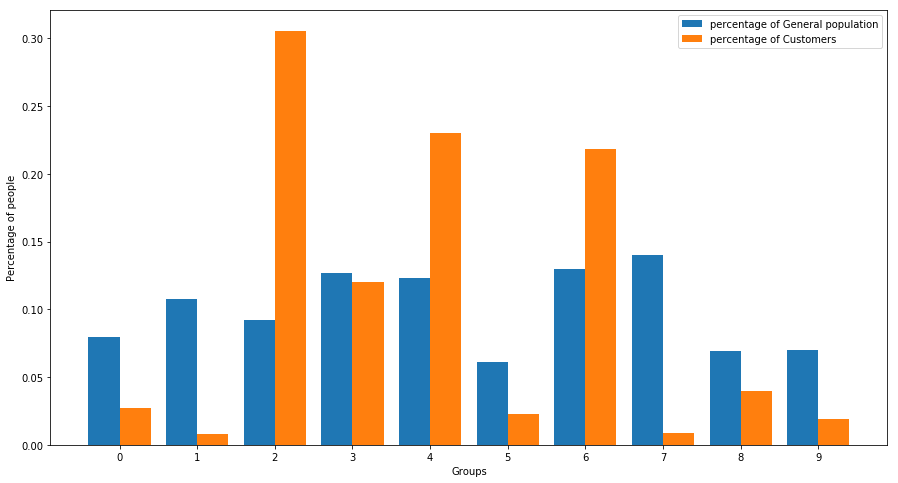

In [29]:
# Plot the distribution of percentage
get_distribution(True)

If the population of one cluster is of great chance to be the customers, then the percentage of that cluster in given customers should be close to or exceeds the percentage of that cluster in the whole population.

From the above graphs we can see that group 2, 3, 4 and 6 are the population that our customers could possibly be, as the percentages of customers in group 2, 4 and 6 exceed the percentages of general population in these 3 groups, and cluster 3 has a close percentage.

## 1.3 Customer segementation  report

In this part, we would explain what it means for a person to be classify into group 2, 5, 8 or 9.

In [30]:
def explain_cluster(cluster, kmeans = kmean_10):
    '''
    
    '''
    center = kmeans.cluster_centers_[cluster]
    components_info = pd.DataFrame({'Component': np.arange(0, len(center)), 'Magnitude': center}).sort_values(by='Magnitude', ascending=False)
    return components_info

In [31]:
def explain_component(component, pca=pca_90_pctg):
    '''
    
    '''
    feature_info = pd.DataFrame({'Feature': cleaned_azdias.columns, 'Weights': pca_90_pctg.components_[component]}).sort_values(by='Weights', ascending=False).iloc[0:10]
    feats = feature_info['Feature'].tolist()
    
    desc = []
    for feat in feats:
        try:
            desc.append(features[features['Attribute'] == feat]['Description'].iloc[0])
        except:
            desc.append('No description')
    feature_info['Description'] = desc
    
    return feature_info

1. For cluster 2: we can see from below dataframe that Component 1 and 0 contribute the most in cluster 2.

In [43]:
explain_cluster(2)

,Component,Magnitude
1,1,5.530202
0,0,4.092034
3,3,1.775282
4,4,1.151491
7,7,1.006327
...,...,...
18,18,-0.268777
17,17,-0.311315
14,14,-0.381347
11,11,-0.429997


2. For cluster 3: we can see from below dataframe that Component 3, 1 and 8 contribute the most in cluster 3.

In [37]:
explain_cluster(3)

,Component,Magnitude
3,3,1.973928
1,1,1.142132
8,8,1.135035
9,9,0.490834
19,19,0.287457
...,...,...
6,6,-0.339030
5,5,-0.418525
4,4,-1.497144
2,2,-3.040360


3. For cluster 4: we can see from below dataframe that Component 0 and 2 contributes the most in cluster 3.

In [38]:
explain_cluster(4)

,Component,Magnitude
0,0,7.622657
2,2,2.606797
3,3,0.960993
39,39,0.287033
6,6,0.260002
...,...,...
9,9,-0.369405
36,36,-0.445221
11,11,-0.466453
4,4,-0.830088


4. For cluster 6: we can see from below dataframe that Component 0 and 1 contribute the most in cluster 6.

In [39]:
explain_cluster(6)

,Component,Magnitude
0,0,3.521422
1,1,1.022719
6,6,0.415584
11,11,0.390245
8,8,0.242969
...,...,...
19,19,-0.203032
9,9,-0.452193
4,4,-1.162117
3,3,-1.545881


Combining all the information above, we could tell that component 0, 1, 2, 3, 8 are the factors of customers segmentation. We then check what features are of importance in these components.

In [44]:
explain_component(0)

,Feature,Weights,Description
289,MOBI_REGIO,0.143429,moving patterns
286,LP_STATUS_FEIN,0.133156,social status fine
108,KBA05_ANTG1,0.132911,number of 1-2 family houses in the cell
170,KBA13_ANTG1,0.132326,No description
288,MOBI_RASTER,0.130019,No description
112,KBA05_AUTOQUOT,0.129907,share of cars per household
119,KBA05_GBZ,0.125535,number of buildings in the microcell
176,KBA13_AUTOQUOTE,0.121024,share of cars per household within the PLZ8
87,FINANZ_MINIMALIST,0.113147,financial typology: low financial interest
285,LP_LEBENSPHASE_FEIN,0.110673,lifestage fine


In [45]:
explain_component(1)

,Feature,Weights,Description
216,KBA13_HERST_BMW_BENZ,0.173175,share of BMW & Mercedes Benz within the PLZ8
249,KBA13_MERCEDES,0.149313,share of MERCEDES within the PLZ8
263,KBA13_SEG_OBEREMITTELKLASSE,0.146791,share of upper middle class cars and upper cla...
184,KBA13_BMW,0.142867,share of BMW within the PLZ8
270,KBA13_SITZE_4,0.135991,number of cars with less than 5 seats in the PLZ8
266,KBA13_SEG_SPORTWAGEN,0.133585,share of sportscars within the PLZ8
120,KBA05_HERST1,0.125622,"share of top German manufacturer (Mercedes, BMW)"
226,KBA13_KMH_211,0.119169,share of cars with a greater max speed than 21...
239,KBA13_KW_121,0.118325,share of cars with an engine power of more tha...
136,KBA05_KW3,0.116049,share of cars with an engine power of more tha...


In [46]:
explain_component(2)

,Feature,Weights,Description
13,CJT_TYP_2,0.171364,No description
296,PRAEGENDE_JUGENDJAHRE,0.165746,dominating movement in the person's youth (ava...
12,CJT_TYP_1,0.163545,No description
88,FINANZ_SPARER,0.157520,financial typology: money saver
291,ONLINE_AFFINITAET,0.155451,online affinity
89,FINANZ_UNAUFFAELLIGER,0.141967,financial typology: unremarkable
311,SEMIO_PFLICHT,0.135830,affinity indicating in what way the person is ...
315,SEMIO_TRADV,0.129411,affinity indicating in what way the person is ...
39,D19_GESAMT_ANZ_24,0.126715,No description
312,SEMIO_RAT,0.120770,affinity indicating in what way the person is ...


In [47]:
explain_component(3)

,Feature,Weights,Description
90,FINANZ_VORSORGER,0.122479,financial typology: be prepared
84,EWDICHTE,0.118740,density of inhabitants per square kilometer
335,ALTERSKATEGORIE_GROB,0.118011,age through prename analysis
292,ORTSGR_KLS9,0.116763,classified number of inhabitants
172,KBA13_ANTG3,0.111570,No description
173,KBA13_ANTG4,0.109397,No description
16,CJT_TYP_5,0.108686,No description
39,D19_GESAMT_ANZ_24,0.106969,No description
295,PLZ8_ANTG4,0.106065,number of >10 family houses in the PLZ8
177,KBA13_BAUMAX,0.103986,No description


In [48]:
explain_component(8)

,Feature,Weights,Description
268,KBA13_SEG_VAN,0.193087,share of vans within the PLZ8
256,KBA13_SEG_GROSSRAUMVANS,0.180533,share of big sized vans within the PLZ8
260,KBA13_SEG_MINIVANS,0.170209,share of minivans within the PLZ8
234,KBA13_KRSSEG_VAN,0.163112,share of vans (referred to the county average)...
212,KBA13_HALTER_65,0.160964,share of car owners between 61 and 65 within t...
122,KBA05_HERST3,0.157335,share of Ford/Opel
189,KBA13_CCM_1401_2500,0.152443,No description
129,KBA05_KRSHERST3,0.142521,share of Ford/Opel (reffered to the county ave...
218,KBA13_HERST_FORD_OPEL,0.141904,share of Ford & Opel/Vauxhall within the PLZ8
213,KBA13_HALTER_66,0.141776,share of car owners over 66 within the PLZ8


We extracted several conclusions from above dataframes about the customers segmentation.
   1. Lots of influential features are about cars. People who have better cars, including cars of big brands or with good attributes are likely to be the customers.
   2. People who have a high online affinity are likely to be the customers.
   3. People who have financial typology of 'be prepared' or 'money saver' are more possible to be the customers than other typologies.
   4. Also, car owners that are over 30 years old are also potential customers compared to other ages.
   
 In this way, we conclude the features of a person who are likely to be the customer.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

We would repeat the data cleaning process using the same cleaning function as above, except we are not dropping the rows this time.

In [6]:
def clean_data(df):
    '''
    
    '''
    
    def feature_trans(x):
        '''
        Clean the 'XX' and string of numbers.
        '''
        if pd.isnull(x) != True:
            try:
                return int(x)
            except:
                return np.nan
    
    df['ORTSGR_KLS9'] = df['ORTSGR_KLS9'].replace({0.0:np.nan})
    df[['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN' , 'LP_LEBENSPHASE_GROB']] = df[['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN' , 'LP_LEBENSPHASE_GROB']].replace({0.0:np.nan})
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({'XX':np.nan})
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(feature_trans)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(feature_trans)
    df['KBA05_MODTEMP'] = df['KBA05_MODTEMP'].replace({6.0:np.nan})
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O':0, 'W':1})
    
    ranges = ['1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B', '3C', '3D', 
              '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E', '5F', '6A', '6B', 
              '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E', '8A', '8B', '8C', '8D', 
              '9A', '9B', '9C', '9D', '9E']
    val_dict = dict(zip(ranges, np.linspace(1, len(ranges), len(ranges))))
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(val_dict)
    
    rows = []
    for i in range(len(values)):
        if 'unknown' in values.iloc[i]['Meaning']:
            rows.append(i)
    unknown_code = values.iloc[rows]
    
    def to_int_list(x):
        '''
        Turn  either an int type number or a string of multiple numbers  into a int list.

        '''
        if type(x) == int:
            return [x]
        else:
            return [ int(i) for i in x.split(',')]


    unknown_code['Value'] = unknown_code['Value'].apply(to_int_list)
    
    count = 1
    for idx in range(len(unknown_code)):
        feature = unknown_code.iloc[idx]['Attribute']
        code = unknown_code.iloc[idx]['Value']
        try:
            df[feature] = df[feature].apply(lambda x: np.nan if x in code else x)
            count += 1
            if count % 5 == 0:
                print(count, 'features are transformed.')
            
        except:
            continue
    print(count, 'features are transformed.')
    
    
#     df = df.iloc[np.where(df.isnull().mean(axis=1) <= 0.1)]
    
    drop_cols = ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'ALTER_KIND4', 'ALTER_KIND3',
                 'TITEL_KZ', 'ALTER_KIND2' ,'ALTER_KIND1', 'KK_KUNDENTYP', 'KBA05_BAUMAX',
                 'AGER_TYP', 'EXTSEL992', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'LNR'] 
    df.drop(columns=drop_cols, inplace=True)
    
    high_correlated = ['ANZ_HAUSHALTE_AKTIV', 'CAMEO_DEU_2015',
                    'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_DATUM'
                    , 'KBA13_ALTERHALTER_61', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_BAUMAX', 'KBA13_HERST_SONST','PLZ8_GBZ',
                     'PLZ8_HHZ', 'KBA13_KMH_250', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB']
    df.drop(columns=high_correlated, inplace=True)
    
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    
    
    return df

In [7]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
mailout_train.shape

(42962, 367)

(array([3.3888e+04, 3.2600e+02, 6.4700e+02, 1.3900e+02, 8.0000e+00,
        9.2000e+01, 0.0000e+00, 8.0000e+01, 7.7100e+02, 7.0110e+03]),
 array([0.        , 0.06893733, 0.13787466, 0.20681199, 0.27574932,
        0.34468665, 0.41362398, 0.48256131, 0.55149864, 0.62043597,
        0.6893733 ]),
 <a list of 10 Patch objects>)

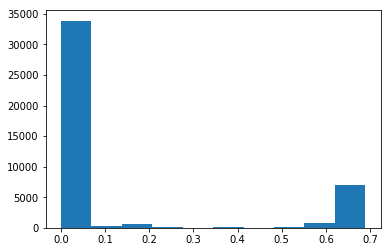

In [9]:
plt.hist(mailout_train.isnull().mean(axis=1))

Clean the MAILOUT data with the same process using clean_data function.

In [10]:
cleaned_data = clean_data(mailout_train)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5 features are transformed.
10 features are transformed.
15 features are transformed.
20 features are transformed.
25 features are transformed.
30 features are transformed.
35 features are transformed.
40 features are transformed.
45 features are transformed.
50 features are transformed.
55 features are transformed.
60 features are transformed.
65 features are transformed.
70 features are transformed.
75 features are transformed.
80 features are transformed.
85 features are transformed.
90 features are transformed.
95 features are transformed.
100 features are transformed.
105 features are transformed.
110 features are transformed.
115 features are transformed.
120 features are transformed.
125 features are transformed.
130 features are transformed.
135 features are transformed.
140 features are transformed.
145 features are transformed.
150 features are transformed.
155 features are transformed.
160 features are transformed.
165 features are transformed.
170 features are transformed.


In [11]:
cleaned_data['RESPONSE'].value_counts()

0.0    42430
1.0      532
Name: RESPONSE, dtype: int64

In [12]:
cleaned_train = cleaned_data.drop(columns=['RESPONSE'])
response = cleaned_data['RESPONSE']

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_train, response, test_size=0.3)

First, we would try a Logistic regression on the cleaned data as a benchmark.

In [14]:
clf = LogisticRegression(max_iter=1000, random_state=42)

In [15]:
clf.fit(X_train, Y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=1000, random_state=42)

In [16]:
Y_pred = clf.predict_proba(X_test)

In [17]:
Y_pred[:, 1]

array([0.01233415, 0.00821658, 0.01115795, ..., 0.00063423, 0.00100896,
       0.00402881])

Since there's an imbalance between the number of customers and the number of people who are not, we would use ROC AUC socre as the measurement to evaluate the prediction result.

In [19]:
roc_auc_score(Y_test, Y_pred[:, 1])

0.6739328102737363

The AUC score is 0.673932. Then we would try other classifiers to see if there could be an improvement.

In [20]:
def clf_res_time(model, X=X_train, y=Y_train, X_test=X_test, y_test=Y_test):
    '''
    Calculate the roc_auc score and time cost for one specific machine 
    learning classifier fit on the cleaned mailout data.
    
    params: model: machine learning classifier
    return: duration: cost time
            score: roc_auc score
    '''
    start = time.time()
    model.fit(X, y)
    pred = model.predict_proba(X_test)[:, 1]
    
    score = roc_auc_score(Y_test, pred)
    end = time.time()
    duration = end - start
    
    return duration, score

We would try methods including Adaboost, RondomForest, GradientBoosting and XGBoosting.

In [81]:
adaboost_clf = AdaBoostClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
gbc_clf = GradientBoostingClassifier(random_state=42)
xgb_clf = XGBClassifier(random_state=42, reg_lambda=0)

In [82]:
clf_res_time(xgb_clf)

(22.81522846221924, 0.7542455920910685)

In [83]:
clfs = [adaboost_clf, rf_clf, gbc_clf, xgb_clf]
times = []
scores = []

for clf in clfs:
    duration, score = clf_res_time(clf)
    times.append(duration)
    scores.append(score)

In [84]:
print(pd.DataFrame({'AUC_scores':scores, 'Time': times}, index=['Adaboost', 'RandomForest', 'GradientBoosting', 'XGboost']))

                  AUC_scores       Time
Adaboost            0.711113  12.130715
RandomForest        0.592606   9.737136
GradientBoosting    0.729366  43.512934
XGboost             0.754246  22.300631


We could see boosting methods the AUC scores. Then we apply cross validation to search for the best parameters.

In [24]:
def search_params(model, params, X=X_train, y=Y_train):
    '''
    Create a GridSearchCV instance to search for best parameters.
    '''
    cv = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='roc_auc')
    cv.fit(X, y)
    
    return cv

1. GradientBoosting: we would choose to test values for learning rate and max_depth.

In [25]:
params = {'learning_rate':[0.05, 0.1, 0.2],
         'max_depth': [3, 4, 5]}
GB_cv = search_params(model=GradientBoostingClassifier(random_state=42), params=params)

In [26]:
roc_auc_score(Y_test, GB_cv.predict_proba(X_test)[:, 1])

0.7431727498610488

In [27]:
GB_cv.best_estimator_

GradientBoostingClassifier(learning_rate=0.05, random_state=42)

2. XGBoost:we would choose to test values for learning rate, max_depth and gamma.

In [71]:
params = {'learning_rate': [0.05, 0.1, 0.2],
          'reg_lambda':[0, 1],
         'max_depth': [3, 4, 5]}
XGBoost_cv = search_params(model=XGBClassifier(random_state=42), params=params)

In [72]:
roc_auc_score(Y_test, XGBoost_cv.predict_proba(X_test)[:, 1])

0.7398056075621253

## Part 3: Kaggle Competition

If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.



In [31]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
mailout_test

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,67615,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,1
42829,67938,0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,2.0,...,4.0,10.0,9.0,6.0,6.0,9.0,3.0,3,1,4
42830,67942,-1,1.0,16.0,14.0,17.0,NaN,NaN,15.0,1.0,...,2.0,1.0,1.0,1.0,1.0,9.0,3.0,2,1,3
42831,67949,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,1.0,4.0,4.0,2.0,6.0,9.0,3.0,3,2,3


In [33]:
LNR = mailout_test['LNR']

In [34]:
cleaned_test = clean_data(mailout_test)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5 features are transformed.
10 features are transformed.
15 features are transformed.
20 features are transformed.
25 features are transformed.
30 features are transformed.
35 features are transformed.
40 features are transformed.
45 features are transformed.
50 features are transformed.
55 features are transformed.
60 features are transformed.
65 features are transformed.
70 features are transformed.
75 features are transformed.
80 features are transformed.
85 features are transformed.
90 features are transformed.
95 features are transformed.
100 features are transformed.
105 features are transformed.
110 features are transformed.
115 features are transformed.
120 features are transformed.
125 features are transformed.
130 features are transformed.
135 features are transformed.
140 features are transformed.
145 features are transformed.
150 features are transformed.
155 features are transformed.
160 features are transformed.
165 features are transformed.
170 features are transformed.


Use XGboost to predict on MAILOUT_TEST data.

In [88]:
test_pred = XGBoost_cv.predict_proba(cleaned_test)[:, 1]

In [86]:
final_pred = pd.DataFrame({'LNR':LNR, 'RESPONSE': test_pred})

In [87]:
# Save the prediction results.
final_pred.to_csv('final_pred.csv', index=False)